In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from statsmodels.stats.contingency_tables import Table2x2
from importlib import reload
import pickle
import PIL

In [2]:
os.chdir('/Volumes/Encrypted/Semiology-Visualisation-Tool/')
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis import Sankey_Functions
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [3]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter

In [4]:
import pywaffle

# Define lists & file paths

In [255]:
from pathlib import Path
# Define paths
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = excel_path
with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
region_names = labels.get_region_names()

In [302]:
semiology_list = list(recursive_items(SemioDict))

# Get df from Excel sheet & query df

If previously run notebook, get pickled results of MEGA_ANALYSIS, QUERY_SEMIOLOGY, normalisatione etc, and then go straight to Get sorted list of semiologies

In [11]:
# with open('scripts/figures/query_results_pickle.pkl', 'rb') as f:
#     query_results = pickle.load(f)
    
# with open('scripts/figures/all_dfs_pickle.pkl', 'rb') as f:
#     all_dfs = pickle.load(f)

If no pickle available, run:

In [273]:
# Exclude data = True
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database,
                              exclude_data=True)
print(original_df.shape)

(2486, 121)


In [274]:
redistribution_spec = {
    'FT': ['FL', 'INSULA', 'Lateral Temporal', 'TL'],
    'TO': ['Lateral Temporal', 'TL', 'OL'],
    'TP': ['Lateral Temporal', 'TL', 'PL'],
    'FTP': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'TPO Junction': ['Lateral Temporal', 'TL', 'PL', 'OL'],
    'PO': ['PL', 'OL'],
    'FP': ['FL', 'PL'],
    'Perisylvian': ['INSULA', 'Lateral Temporal', 'TL', 'FL', 'PL'],
    'Sub-Callosal Cortex': ['Ant Cing (frontal, genu)', 'CING']
}

In [275]:
redistributed_df = copy.deepcopy(original_df)
for from_region, destination_regions in redistribution_spec.items():
    for destination in destination_regions:
        redistributed_df[destination] = original_df[destination].fillna(0) + original_df[from_region].fillna(0)
redistributed_df = redistributed_df.drop(redistribution_spec.keys(), 'columns')

In [276]:
region_names.keys()

dict_keys(['all', 'top_level', 'of_interest', 'of_interest_minus_tl', 'top_level_all_other', 'top_level_temporal', 'low_level_temporal_all', 'low_level_temporal_of_interest'])

In [277]:
region_names_re = region_names
region_names_re['top_level'] =  ['TL',
                     'FL',
                     'CING',
                     'PL',
                     'OL',
                     'INSULA',
                     'Hypothalamus',
                     'Cerebellum',]
region_names_re['top_level_all_other'] = ['Cerebellum']

In [278]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [279]:
from mega_analysis.crosstab.mega_analysis.exclusions import exclude_ET, exclude_cortical_stimulation, exclude_spontaneous_semiology

df = copy.deepcopy(redistributed_df)
df_SS = exclude_ET(df)
df_SS = exclude_cortical_stimulation(df_SS)
df_TS = exclude_spontaneous_semiology(df)

all_dfs = {
    'full': df,
    'spontaneous': df_SS,
    'topology':  df_TS,
}

In [303]:
query_results = {}
for key, df in all_dfs.items():
    query_results[key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [13]:
with open('scripts/figures/query_results_pickle.pkl', 'wb') as f:
    pickle.dump(query_results, f)
with open('scripts/figures/all_dfs_pickle.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

# Get sorted list of semiologies

In [197]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [281]:
sorted_semiologies = sort_semiologies_by_n(query_results['full'])

In [282]:
# ali

# find all semiologies that occur more than 100 times in all and SS (localising as above, not datapoints)

# all data
i = 0
full_semio = []
full_loc_values = []
for semio in query_results['full'].keys():
    n_localising = query_results['full'][semio]['num_query_loc']
    full_loc_values.append(n_localising)
    if n_localising > 0:  # 410 for top 12
        i += 1
        # print(semio) 
        full_semio.append(semio)

# spontaneous SS data
i = 0
SS_semio = []
SS_loc_values = []
for semio in query_results['spontaneous'].keys():
    n_localising = query_results['spontaneous'][semio]['num_query_loc']
    SS_loc_values.append(n_localising)
    if n_localising > 100: 
        i += 1
        # print(semio) 
        SS_semio.append(semio)

# topological TS data
i = 0
TS_semio = []
TS_loc_values = []
for semio in query_results['topology'].keys():
    n_localising = query_results['topology'][semio]['num_query_loc']
    TS_loc_values.append(n_localising)
    if n_localising > 100: 
        i += 1
        # print(semio) 
        TS_semio.append(semio)


over_100 = [i for i in SS_semio if i in full_semio and i in TS_semio]
print (len(over_100))
semiologies_100 = over_100

12


13795.0
3522.0
9931.0


/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


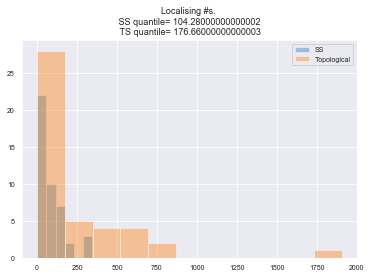

In [283]:
# ali: justification for using top occuring semiologies

print(np.sum(full_loc_values))
print(np.sum(SS_loc_values))
print(np.sum(TS_loc_values))

a = np.quantile(SS_loc_values, 0.66)
b = np.quantile(TS_loc_values, 0.66)

sns.distplot(SS_loc_values, kde=False, label='SS')
sns.distplot(TS_loc_values, kde=False, label='Topological')
plt.legend()
plt.title(f"Localising #s. \n SS quantile= {a} \n TS quantile= {b}")
plt.show()

# if we want to see the top 3rd of the most frequently occuring semiologies that occur in both spontaneous and topological studies, we use >104 for SS and >176 for TS.
# this gives us 10 semiologies rather than 12 above. the two differences are somatosensory and Vocalisation - so by showing the these 12 that occur more than 100 times in both databases, we are shoing more than the top 3rd of all the data in the Semio2Brain database.

In [34]:
core_semiologies = [semiology for semiology in sorted_semiologies \
 if semiology !='No Semiology - Only Stimulation Studies' and not semiology.startswith('Postictal')]

# Plotter params

In [21]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [24]:
legend_labels = ['All studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

order_of_interest = ['FL','CING', 'PL', 'OL', 'INSULA', 'Hypothalamus', 'All other',
                     'TL', 'Anterior (temporal pole)', 'Lateral Temporal', 'Mesial Temporal',
                     'Posterior Temporal', 'Basal (including Fusiform OTMG)',]

# Bold top level lobes, not temporal subregions
special_y_mask = [not region in region_names['low_level_temporal_of_interest'] for region in order_of_interest]
special_y_index = [i for i, val in enumerate(special_y_mask) if val]

---
# Figure 1 - P (Localisation | Semiology)
---

In [304]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names_re,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:415: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [ ]:
results['full']['raw_counts']

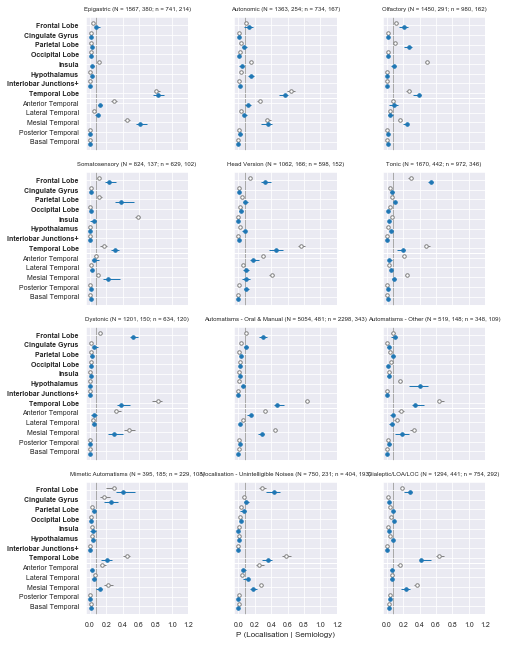

In [305]:
sns.set_style("darkgrid")
# sns.boxplot(data=data, palette="deep")
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['raw_counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['raw_counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               localising_n = query_results, fontsize=6,
                               special_y_titles = special_y_index,
                                figsize = (7, 9),
                              )

# plt.savefig(f'scripts/figures/working_figures_2/fig-1/both n.eps', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

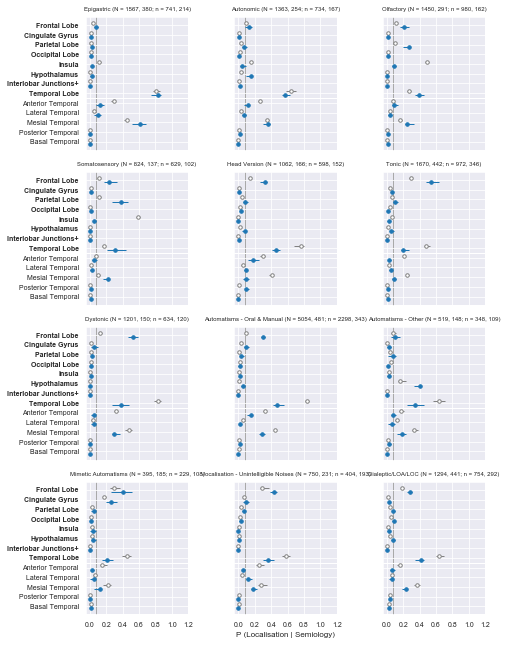

In [253]:
# New interlobar regions - 
sns.set_style("darkgrid")
# sns.boxplot(data=data, palette="deep")
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['raw_counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['raw_counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               localising_n = query_results, fontsize=6,
                               special_y_titles = special_y_index,
                                figsize = (7, 9),
                              )

# plt.savefig(f'scripts/figures/working_figures_2/fig-1/both n.eps', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

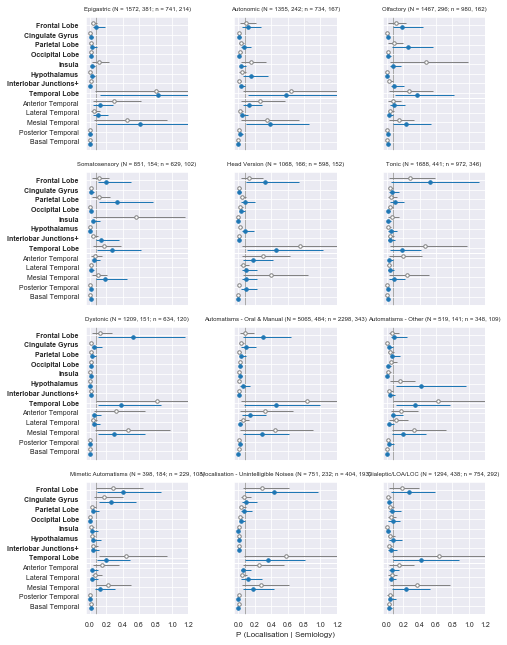

In [140]:
sns.set_style("darkgrid")
# sns.boxplot(data=data, palette="deep")
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['raw_counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['raw_counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               localising_n = query_results, fontsize=6,
                               special_y_titles = special_y_index,
                                figsize = (7, 9),
                              )

# plt.savefig(f'scripts/figures/working_figures_2/fig-1/both n.eps', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

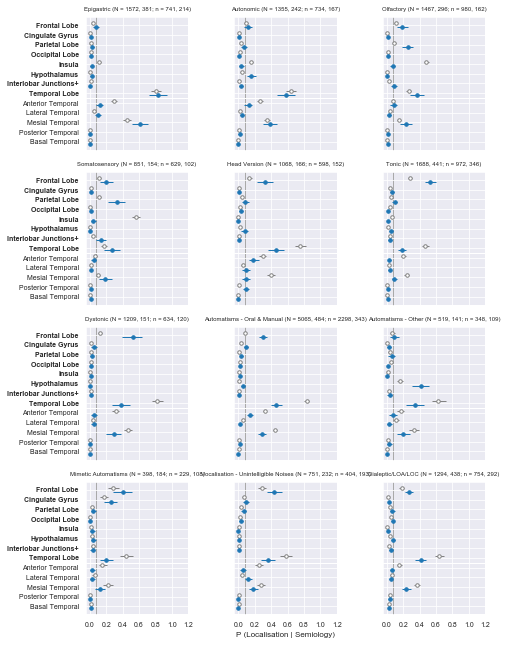

In [146]:
reload(plotter)

sns.set_style("darkgrid")
# sns.boxplot(data=data, palette="deep")
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['raw_counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['raw_counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               localising_n = query_results, fontsize=6,
                               special_y_titles = special_y_index,
                                figsize = (7, 9),
                              )

# plt.savefig(f'scripts/figures/working_figures_2/fig-1/both n.eps', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

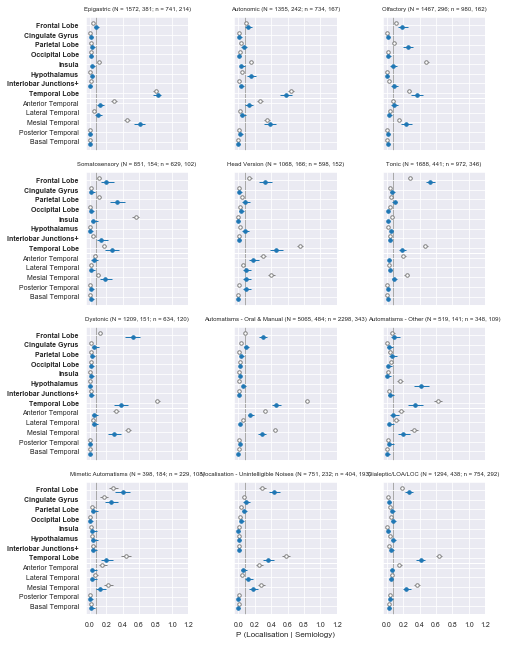

In [147]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # 'zone'
        region_names = region_names,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'binomial',
#         bootstrapping_samples = 1000, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

sns.set_style("darkgrid")
# sns.boxplot(data=data, palette="deep")
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = results['full']['proportion'],
                               confint_df_1 = results['full']['confints'],
                               counts_df_1 = results['full']['raw_counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = results['spontaneous']['proportion'],
                               confint_df_2 = results['spontaneous']['confints'],
                               counts_df_2 = results['spontaneous']['raw_counts'],
                               y_labels = labels.clean_localisations(results['full']['proportion'].columns),
                               overlapping = False,
                               ax_titles = labels.clean_semiologies(results['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
#                                n= options - can omit. N=Datapoints. n=#of semiologies.
                               localising_n = query_results, fontsize=6,
                               special_y_titles = special_y_index,
                                figsize = (7, 9),
                              )

# plt.savefig(f'scripts/figures/working_figures_2/fig-1/both n.eps', dpi=300, pad_inches=0.5)
# plt.savefig(repo_dir / 'images' / 'Brain' / 'test_fig-1_raw_10-bootstrap_zone.eps', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [142]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = core_semiologies,
        drop_other_semiology = False,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10, 
    order_of_regions = order_of_interest)
    
    results[study_type] = result

<Figure size 432x288 with 0 Axes>

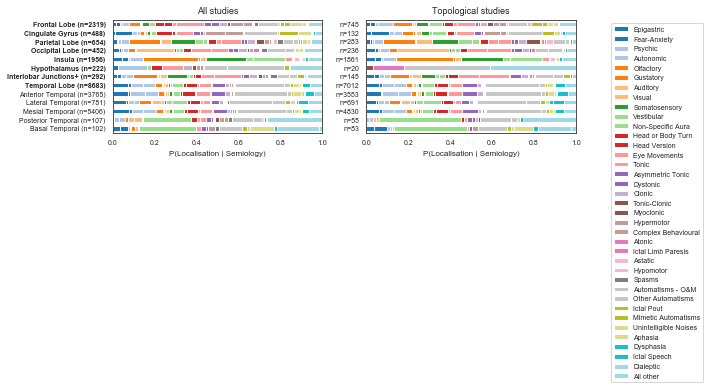

In [36]:
axis = 'semiology'

sns.set_style('white')
sns.despine(left=True)
counts_form = 'raw_counts'

y_sums_1 = [int(n) for n in results['full'][counts_form].sum(0)]
y_sums_2 = [int(n) for n in results['topology'][counts_form].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(results['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", 
                                    as_cmap=True
                                    )
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)
plotter.plot_stacked_hbar(results['full']['proportion'].T,
                          ax=axs[0],
                          ax_title='All studies',
                          axis=axis,
                          color_palette=color_palette, 
                         special_y_titles = special_y_index)

plotter.plot_stacked_hbar(results['topology']['proportion'].T,
                          ax=axs[1],
                          ax_title='Topological studies',
                          axis=axis,
                          color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(results['full']['proportion'].index))

axs[0].set_yticklabels(combine_labels_1[::-1])
axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
# plt.savefig(f'scripts/figures/working_figures_2/fig-2/bar/raw_temporal_breakdown.eps', dpi=300, pad_inches=0.5)

In [31]:
from pywaffle import Waffle

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/matplotlib/figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


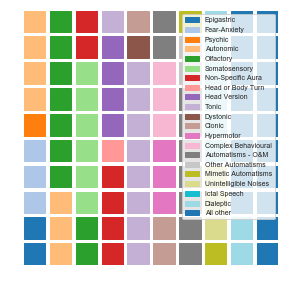

In [111]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,  # Either rows or columns could be omitted
    values=results['topology']['proportion']['FL']*100,
    cmap_name = 'tab20',
    legend = {'labels': labels.clean_semiologies(results['full']['proportion'].index)}
)
fig.show()

In [110]:
# plots = {}
# i = 0
# for region, region_values in dict(results['topology']['proportion']).items():
#     col = i % 3 
#     row = i // 3
#     plots[((col),(row),(i))] = {
#         'values': list((region_values.values*100).astype(int)),
#         'labels': list(region_values.index),
#         'title': {
#                 'label': region
#         }
#     }
#     i += 1

# fig = plt.figure(
#     FigureClass=Waffle,
#     rows=10,
#     columns=10,  # Either rows or columns could be omitted
#     cmap_name = 'tab20',
#     plots = plots
# )
# fig.show()

In [51]:
melted = results['full']['proportion'].reset_index().melt(id_vars=['index'], var_name=['localisation'])

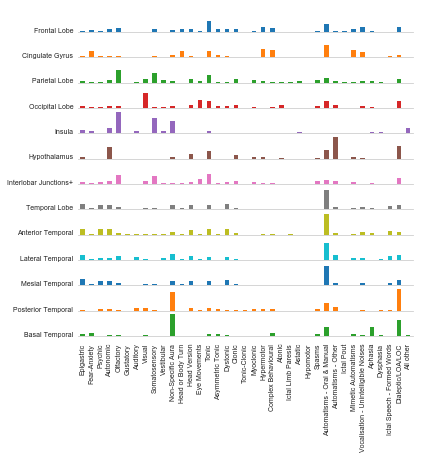

In [119]:
sns.set_style("whitegrid")
axs = results['full']['proportion'].plot(kind='bar', subplots=True, sharey=True, 
              figsize=(6, 6), legend=False, yticks=[], 
              grid=False, ylim=(0, 0.27), edgecolor='none')

sns.despine(left=True)
for ax in axs:
    ax.set_title('')
    sername = ax.get_legend_handles_labels()[1][0]
    ax.text(-1, 0, labels.clean_localisations(sername)[0], fontsize=7, ha='right')

plt.subplots_adjust(wspace = 0.001, hspace = 0.15)
# plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/bar/panel_bar.png', dpi=300, pad_inches=3)

In [37]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = core_semiologies,
        drop_other_semiology = False,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10, 
    order_of_regions = order_of_interest)
    
    results[study_type] = result

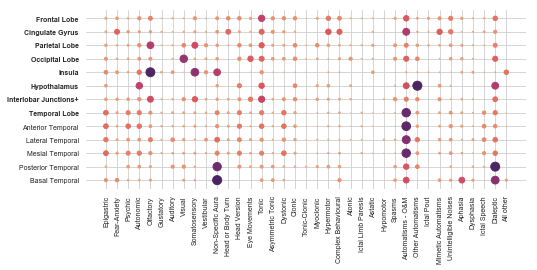

In [121]:
df = results['full']['proportion']

x = list(range(df.shape[0]))*df.shape[1]
y = []
for i in range(df.shape[1]):
    y += [i]*df.shape[0]

s = df.T.values.flatten() 
    
    
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize=(7.5, 3.8))
plt.scatter(x,
            y,
            s=s*300,
            c=s,
            cmap='flare',
            )
plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)

axs.invert_yaxis()

special_y_titles = special_y_index
inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
for y in special_y_titles:
    axs.get_yticklabels()[y].set_weight("bold")
for y in inverse_special_titles:
    # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
    pass

plt.tight_layout()
sns.despine(left=True, bottom=True)

plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/all_studies.png', dpi=300, pad_inches=0.5)

In [133]:
results = {}
reload(interogate_queries)
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = core_semiologies,
        drop_other_semiology = False,
        merge_other_regions = False,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10, )
#     order_of_regions = order_of_interest)
    
    results[study_type] = result

In [138]:
results['full']['counts']['Sub-Callosal Cortex']

Epigastric                              0.957364
Fear-Anxiety                            0.852459
Psychic                                 1.943609
Autonomic                               0.000000
Olfactory                               1.786691
Gustatory                               0.000000
Auditory                                0.000000
Visual                                  0.000000
Somatosensory                           0.000000
Vestibular                              0.000000
Non-Specific Aura                       0.000000
Head or Body Turn                       0.000000
Head Version                            0.966074
Eye Movements                           0.000000
Tonic                                   0.939130
Asymmetric Tonic                        0.886364
Dystonic                                0.000000
Clonic                                  0.000000
Tonic-Clonic                            0.000000
Myoclonic                               0.000000
Hypermotor          

In [124]:
region_names['top_level_all_other']

['Perisylvian',
 'TP',
 'TO',
 'FP',
 'Cerebellum',
 'FT',
 'Sub-Callosal Cortex',
 'PO',
 'FTP',
 'TPO Junction']

In [129]:
results['full']['counts']['All other'].sum()

264.17751240423206

In [43]:
# fig, axs = plt.subplots(figsize=(7, 7))
g = sns.catplot(x="index", y="value", col="variable",
                data=melted, saturation=.5,
                col_wrap=4,
                kind="bar", ci=None, aspect=1)

g.fig.set_size_inches(7,7)


NameError: name 'melted' is not defined

In [ ]:
df = results['topology']['proportion']

x = list(range(df.shape[0]))*df.shape[1]
y = []
for i in range(df.shape[1]):
    y += [i]*df.shape[0]

s = df.T.values.flatten() 
    
    
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize=(7.5, 3.8))
plt.scatter(x,
            y,
            s=s*300,
            c=s,
            cmap='flare',
            )
plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)

axs.invert_yaxis()

special_y_titles = special_y_index
inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
for y in special_y_titles:
    axs.get_yticklabels()[y].set_weight("bold")
for y in inverse_special_titles:
    # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
    pass

plt.tight_layout()
# plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heat_size_map_all_semiologies_non_zero.png', dpi=300, pad_inches=0.5)

AttributeError: 'silent_list' object has no attribute 'set_weight'

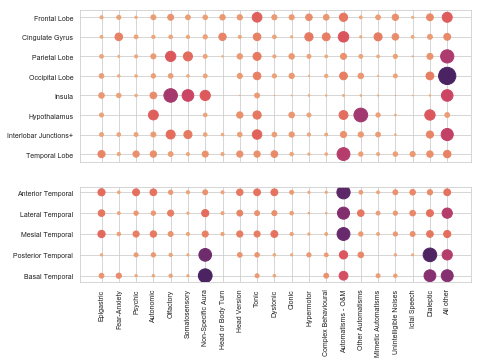

In [334]:
df_1 = results['full']['proportion'].iloc[:,:8]
df_2 = results['full']['proportion'].iloc[:,8:]

sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharey=False, sharex=True, gridspec_kw={'height_ratios': [8, 5]})

for ax_n, df in enumerate([df_1, df_2]):
    x = list(range(df.shape[0]))*df.shape[1]
    y = []
    for i in range(df.shape[1]):
        y += [i]*df.shape[0]
        
    s = df.T.values.flatten()    
    
    axs[ax_n].scatter(x,
                y,
                s=s*700,
                c=s,
                cmap='flare',
                )
    
    plt.sca(axs[ax_n])
    plt.yticks(range(df.shape[1]), labels.clean_localisations(df.columns))
    plt.xticks(range(df.shape[0]), labels.clean_semiologies(df.index), rotation=90)
    axs[ax_n].invert_yaxis()

axs[0].get_yticklabels().set_weight("bold")

#     special_y_titles = special_y_index
#     inverse_special_titles = [f for f in range(results['full']['proportion'].shape[0]) if f not in special_y_titles]
#     for y in special_y_titles:
#         axs.get_yticklabels()[y].set_weight("bold")
#     for y in inverse_special_titles:
#         # axs[ax_n, 0].get_yticklabels()[y].set_color("dimgrey")
#         pass

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heat_size_map_split.eps', dpi=300, pad_inches=0.5)

# spearman's for brain ROIs: Generative similarity ?structutal and functional connectivity

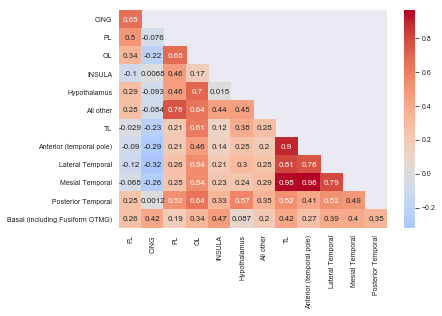

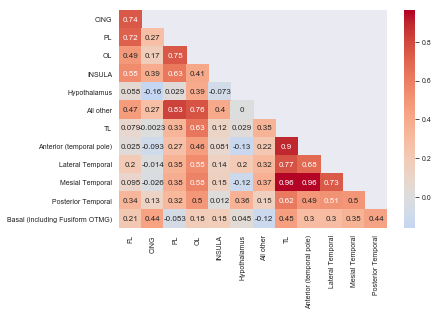


 correlation between all and TS
FL 0.006291793725930202
CING 0.0005344328458721338
PL 3.778521170439727e-05
OL 1.9915823245093213e-06
INSULA 8.595008883805562e-11
Hypothalamus 0.014515417167178999
All other 5.271684392264186e-06
TL 4.622988667749731e-11
Anterior (temporal pole) 1.6803172573075118e-17
Lateral Temporal 6.818646154482452e-15
Mesial Temporal 4.440279007149216e-15
Posterior Temporal 0.00015922346440728336
Basal (including Fusiform OTMG) 5.7839111249223594e-08


In [253]:
# spearman's for brain ROIs

df_ROI_all = results['full']['proportion']
df_ROI_TS = results['topology']['proportion']

# # check distributions
# sns.jointplot(x="FL", y="PL", data=df_ROI_all, alpha=0.4)
# sns.jointplot(x="CING", y="FL", data=df_ROI_TS, alpha=0.4, color='red')
# plt.show()

# correlations
corr_all = df_ROI_all.corr(method = 'spearman')
corr_TS = df_ROI_TS.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_all, dtype=bool))
mask = mask[1:, :-1]
corr_all_diag = corr_all.iloc[1:,:-1].copy()
corr_TS_diag = corr_TS.iloc[1:,:-1].copy()

a = sns.heatmap(corr_all_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.yticks(rotation=0)
plt.show()
sns.heatmap(corr_TS_diag, annot = True, cmap='coolwarm', center=0, mask=mask)
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS.png', dpi=300, pad_inches=0.5)
plt.show()

# check the correlation between the all and TS dataframes
from scipy.stats import spearmanr
print('\n correlation between all and TS')
for lobe in df_ROI_all:
    r, p = spearmanr(df_ROI_all[lobe], df_ROI_TS[lobe])
    print (lobe, p) #  hypothalamus has the biggest change from all to TS with p=0.014 with bonferroni, FL is also not correlated (p>0.05/8+) ie changes from all to TS

# corr_all
corr_TS.to_csv(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TSfilter.csv')

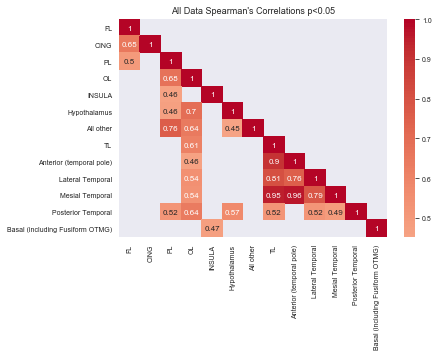

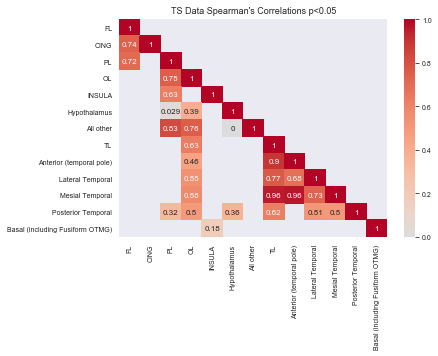

In [254]:
# only significant associations:

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# get p values and mask
p_values_all = corr_sig(df_ROI_all)
mask_all = np.invert(np.tril(p_values_all<0.05))
p_values_TS = corr_sig(df_ROI_all)
mask_TS = np.invert(np.tril(p_values_TS<0.05))

# plot with mask
corr_all = df_ROI_all.corr(method = 'spearman')
a = sns.heatmap(corr_all, annot = True, cmap='coolwarm', center=0, mask=mask_all)
plt.title("All Data Spearman's Correlations p<0.05")
plt.yticks(rotation=0)
plt.show()

corr_TS = df_ROI_TS.corr(method = 'spearman')
sns.heatmap(corr_TS, annot = True, cmap='coolwarm', center=0, mask=mask_TS)
plt.title("TS Data Spearman's Correlations p<0.05")
plt.savefig(repo_dir / 'images' / 'Brain' / 'Spearman_Correlations_TS_significant.png', dpi=300, pad_inches=0.5)
plt.show()

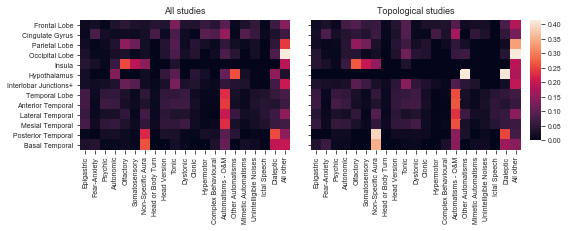

In [278]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 2.9), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .38, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  
plt.tight_layout()

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(results['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(results['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(results['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(results['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures_2/fig-2/heatmap/heatmap.eps', dpi=300, pad_inches=0.5)

# 2b - Region-specific subplots

- Q - use full, SS or topology?
- ***NOT RIGHT - NEEDS TO BE REWRTTTEN WITH NEW NORMALISATION

In [663]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [34]:
axis = 'zone'
normalised_or_not = 'normalised'

In [35]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [36]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [37]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

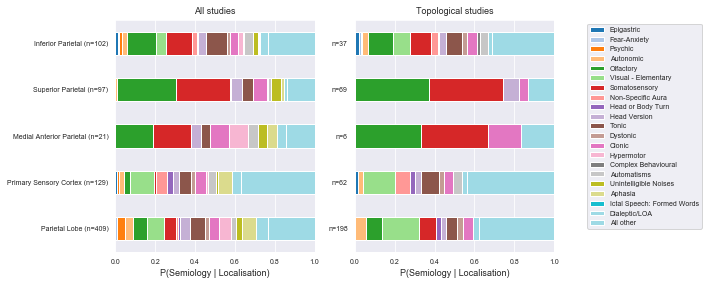

In [39]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

#Choose from {cing_processed_dfs, pl_processed_dfs, sma_processed_dfs}
processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [279]:
def odds_ratio_df(counts, total_row, log_odds=False):
    melted = counts.reset_index().melt(id_vars='index')
    melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
    melted['localisation_total'] = np.zeros(len(melted))
    for localisation, total in total_row.to_dict().items():
        mask = melted['localisation'] == localisation
        melted.loc[mask, 'localisation_total'] = total
        
    melted['c'] = melted['localisation_total'] - melted['a']
    
    melted['semiology_total'] = np.zeros(len(melted))
    for semiology, total in counts.sum(1).to_dict().items():
        mask = melted['semiology'] == semiology
        melted.loc[mask, 'semiology_total'] = total
        
    melted['b'] = melted['semiology_total']-melted['a']
    
    melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])
    
    melted['OR'] = np.nan
    melted['OR_lower_ci'] = np.nan
    melted['OR_upper_ci'] = np.nan
    
    for i in melted.index:
        contingency_table = Table2x2(
        [[melted.loc[i, 'a'], melted.loc[i, 'b']],
         [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
        
        if not log_odds:
            melted.loc[i, 'OR'] = contingency_table.oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
        else:
            melted.loc[i, 'OR'] = contingency_table.log_oddsratio
            melted.loc[i, 'OR_lower_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[0]
            melted.loc[i, 'OR_upper_ci'] = contingency_table.log_oddsratio_confint(alpha = 0.05)[1]

    or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
    or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
    or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')
    
    or_dfs = {
        'counts': counts,
        'or': or_pivot,
        'confints': (or_l_pivot, or_u_pivot)
    }
    
    return or_dfs

In [280]:
order = ['Anterior (temporal pole)',
             'Lateral Temporal',
             'Mesial Temporal',
             'Posterior Temporal',
             'Basal (including Fusiform OTMG)',
             'Hypothalamus',
             'PL',
             'CING',
             'OL',
             'FL',
             'INSULA',
             'All other',
             ]

In [281]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology', # or'zone'
        region_names = region_names,
        normalise = True,
        temporal_status = 'both',
        semiologies_of_interest = semiologies_100,
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 1000, 
        order_of_regions = order_of_interest)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:416: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [282]:
regions_of_interest = region_names['low_level_temporal_of_interest']+region_names['of_interest']
total_row = all_dfs['full'][regions_of_interest].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

In [284]:
for data_type in ['full', 'spontaneous']:
    odds_dfs[data_type] = interogate_queries.order_regions(odds_dfs[data_type], order_of_interest)

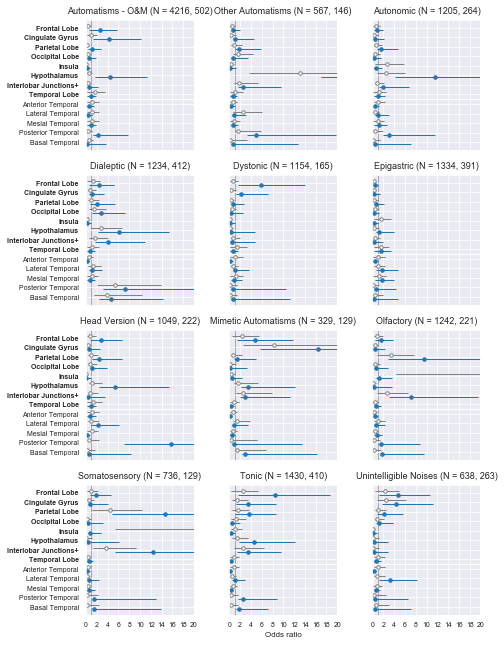

In [285]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
    figsize = (7, 9),
    plotter_settings = plotter_settings,
    special_y_titles = special_y_index,
)

plt.savefig(f'scripts/figures/working_figures_2/fig-3/normalised_temporal_breakdown_2.eps', dpi=300, pad_inches=0.5)

## TL as a single category

In [33]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = True,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:164: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [48]:
total_row = all_dfs['full'][region_names['of_interest']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
odds_dfs = {}
odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = False)
odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = False)

(<Figure size 504x576 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c38a2e0>,
       dtype=object))

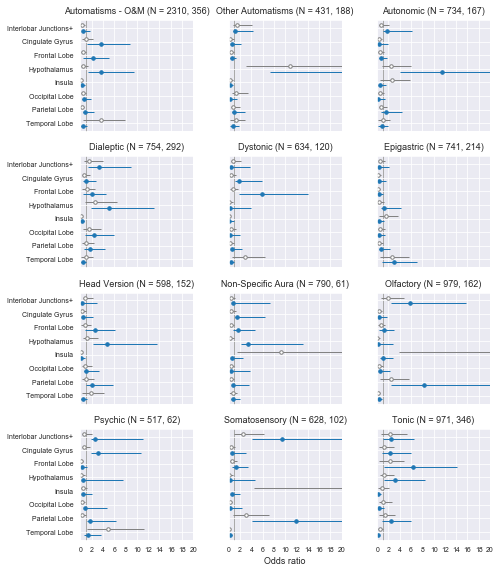

In [49]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = odds_dfs['full']['or'],
    confint_df_1 = [df for df in odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = odds_dfs['spontaneous']['or'],
    confint_df_2 = [df for df in odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'],
    y_labels = labels.clean_localisations(odds_dfs['full']['or'].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(odds_dfs['full']['or'].index),
    xlim = [-0.05,20],
    xticks = np.arange(0, 21, 2),
    vline = 1.0,
    xlabel = 'Odds ratio',
#     figsize = (7, 9),
    plotter_settings = plotter_settings,
)

# plt.savefig(f'scripts/figures/working_figures/fig-3/normalised_top_level.eps', dpi=300, pad_inches=0.5)

## Log odds
- gets weird - confidence limits don't include point estimate sometimes - need to investigate

In [70]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'semiology',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-12:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10)
    
    results[study_type] = result

/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py:164: RuntimeWarning: invalid value encountered in true_divide
  top_level_ratio = (localising.values.T/all_regions.sum(1).values)[0]


In [71]:
total_row = all_dfs['full'][region_names['low_level_temporal_of_interest']+region_names['of_interest_minus_tl']].sum()
total_row['All other'] = all_dfs['full'][region_names['top_level_all_other']].sum().sum()
log_odds_dfs = {}
log_odds_dfs['full'] = odds_ratio_df(results['full']['counts'], total_row, log_odds = True)
log_odds_dfs['spontaneous'] = odds_ratio_df(results['spontaneous']['counts'], total_row, log_odds = True)

(<Figure size 504x648 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ca34ee0>,
       dtype=object))

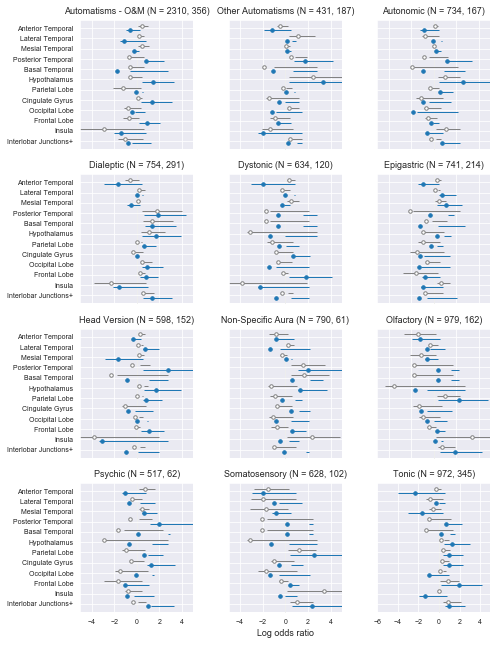

In [72]:
sns.set_style('darkgrid')
plotter.plot_proportion_ci_forest_plot(
    proportion_df_1 = log_odds_dfs['full']['or'][order],
    confint_df_1 = [df[order] for df in log_odds_dfs['full']['confints']],
    counts_df_1 = results['full']['counts'][order],
    colors = colors,
    legend_labels = legend_labels,
    proportion_df_2 = log_odds_dfs['spontaneous']['or'][order],
    confint_df_2 = [df[order] for df in log_odds_dfs['spontaneous']['confints']],
    counts_df_2 = results['spontaneous']['counts'][order],
    y_labels = labels.clean_localisations(log_odds_dfs['full']['or'][order].columns),
    overlapping=False,
    ax_titles = labels.clean_semiologies(log_odds_dfs['full']['or'][order].index),
    xlim = [-5,5],
    xticks = np.arange(-6, 6, 2),
    vline = 0,
    xlabel = 'Log odds ratio',
    figsize = (7, 9),
    plotter_settings = plotter_settings,
)

# plt.savefig('/Users/karan/Downloads/or_log_v1.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

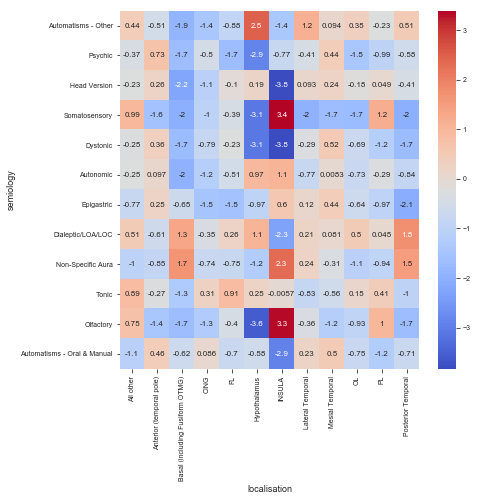

In [78]:
# Log odds
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(log_odds_dfs['full']['or'].loc[sorted_semiologies[-12:]], cbar=True, annot=True, cmap='coolwarm')

# # fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

# NMI/Correlation

In [709]:
import dython

In [765]:
results = {}
for study_type, query_result in query_results.items():
    result = interogate_queries.summarise_query(
        query_result,
        axis = 'zone',
        region_names = region_names,
        normalise = True,
        merge_temporal = False,
        semiologies_of_interest = sorted_semiologies[-20:],
        drop_other_semiology = True,
        merge_other_regions = True,
        drop_other_regions = False,
        confint_method = 'bootstrap',
        bootstrapping_samples = 10000)
    
    results[study_type] = result

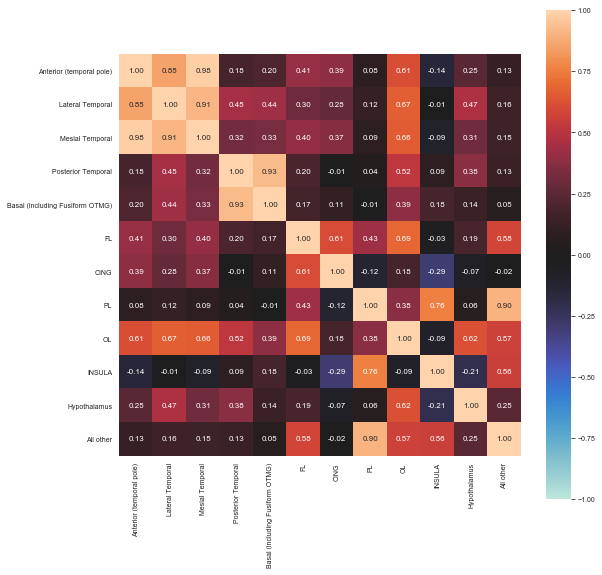

<Figure size 432x288 with 0 Axes>

In [766]:
dython.nominal.associations(results['full']['counts'], theil_u=True, figsize=(9, 9))
plt.tight_layout()

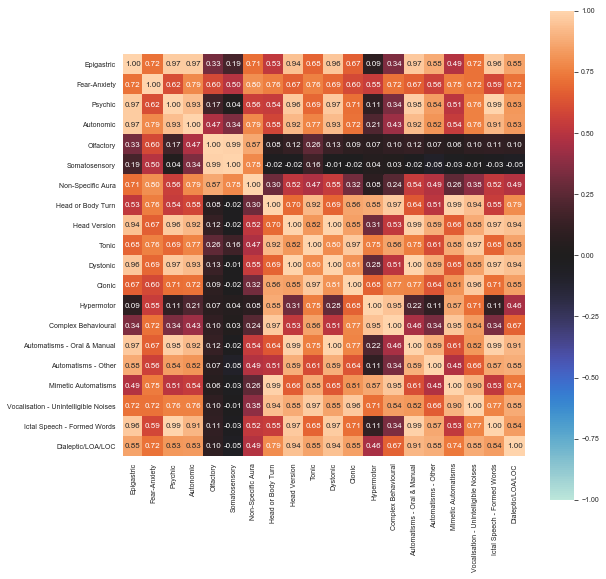

<Figure size 432x288 with 0 Axes>

In [767]:
dython.nominal.associations(results['full']['counts'].T, theil_u=True, figsize=(9, 9))
plt.tight_layout()

----
## Reference
----

In [290]:
query_results = {}
query_results['raw'] = {}
for key, df in all_dfs['raw'].items():
    query_results['raw'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [362]:

top_level_normalised_df = Sankey_Functions.normalise_top_level_localisation_cols_OTHER(copy.deepcopy(original_df))[0]
all_dfs['top_level_normalised'] = {
    'full': top_level_normalised_df,
    'spontaneous': top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  top_level_normalised_df[top_level_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [363]:
query_results['top_level_normalised'] = {}
for key, df in all_dfs['top_level_normalised'].items():
    query_results['top_level_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [364]:

temporal_normalised_df = Sankey_Functions.normalise_localisation_cols_OTHER_SplitTL(copy.deepcopy(original_df))[0]
all_dfs['temporal_normalised'] = {
    'full': temporal_normalised_df,
    'spontaneous': temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  temporal_normalised_df[temporal_normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [365]:
query_results['temporal_normalised'] = {}
for key, df in all_dfs['temporal_normalised'].items():
    query_results['temporal_normalised'][key] = query_semiology_wrapper(df, semiology_list, semiology_dict_path)

In [440]:
with open('scripts/figures/query_results_pickle.pkl', 'wb') as f:
    pickle.dump(query_results, f)
    
with open('scripts/figures/all_dfs_pickle.pkl', 'wb') as f:
    pickle.dump(all_dfs, f)

In [549]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-12:]
processed_dfs = {}
for normalised_type, sub_query_results in query_results.items():
    processed_dfs[normalised_type] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_type][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            bootstrapping_samples=1000,
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

TypeError: summarise_query() got an unexpected keyword argument 'other_regions_included'

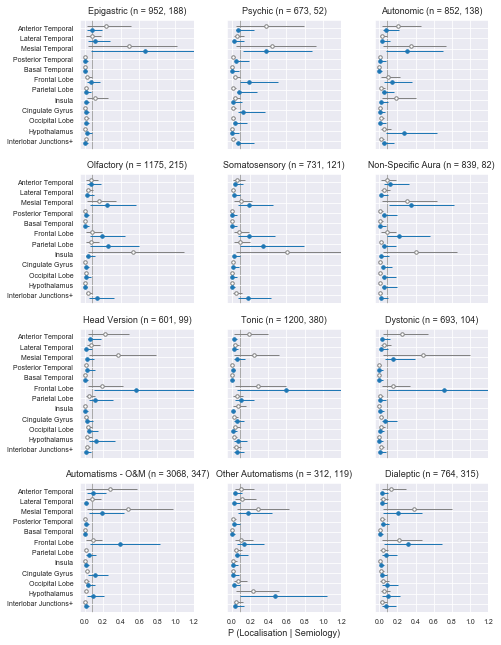

In [303]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'
fig, axs = plotter.plot_proportion_ci_forest_plot(
                               proportion_df_1 = processed_dfs[normalisation]['full']['proportion'],
                               confint_df_1 = processed_dfs[normalisation]['full']['confints'],
                               counts_df_1 = processed_dfs['raw']['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs[normalisation]['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs[normalisation]['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['raw']['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(processed_dfs[normalisation]['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(processed_dfs[normalisation]['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                               xlim = [-0.05,1.2],
                               xticks = np.arange(0, 1.3, 0.2),
                               figsize = (7, 9)
                              )

plt.savefig(F'scripts/figures/working_figures/fig-1/{normalisation}_not_bootstrapped.eps', dpi=300, pad_inches=0.5)

In [56]:
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
# regions_of_interest = region_names['of_interest']
semiologies_of_interest = sorted_semiologies[-20:]
axis = 'zone'

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(query_result,
                                                                      axis = axis,
                                                                      region_names = region_names,
                                                                      confint_method = 'binomial',
                                                                      merge_temporal = False,
                                                                    #   other_regions_included = True,
                                                                      semiologies_of_interest = semiologies_of_interest,
                                                                    #   regions_of_interest = regions_of_interest,
                                                                      drop_other_semiology = False)

KeyError: 'query_inspection'

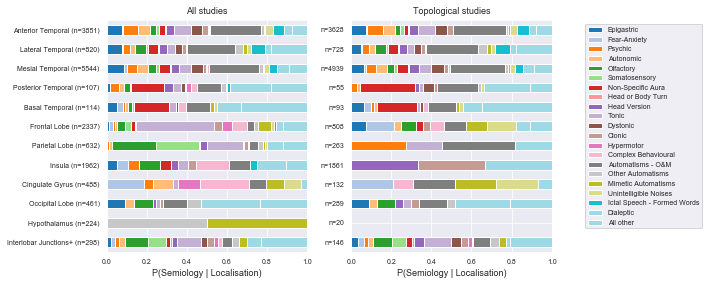

In [103]:
sns.set_style('darkgrid')
normalisation = 'temporal_normalised'

y_sums_1 = [int(n) for n in processed_dfs['raw']['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in processed_dfs['raw']['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(processed_dfs[normalisation]['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

color_palette =  sns.color_palette("tab20", as_cmap=True)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plotter.plot_stacked_hbar(processed_dfs[normalisation]['full']['proportion'], ax=axs[0],
                                      ax_title='All studies', axis=axis, color_palette=color_palette)
plotter.plot_stacked_hbar(processed_dfs[normalisation]['topology']['proportion'], ax=axs[1],
                                      ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs[normalisation]['topology']['proportion'].index))

axs[0].set_yticklabels(combine_labels_1[::-1])
axs[1].set_yticklabels(n_labels_2[::-1])

plt.tight_layout()
plt.savefig(f'scripts/figures/working_figures/fig-2/bar/{normalisation}.eps', dpi=300, pad_inches=0.5)